# Pairs Trading Strategy

---

## **1. Introduction**

Pairs trading is a market-neutral trading strategy that involves identifying two stocks with historically similar price movements. This relationship is quantified during a **formation period**, and deviations from the usual relationship during a subsequent **trading period** create opportunities for profit. The strategy operates by:
1. **Shorting** the outperforming stock (the "winner").
2. **Going long** on the underperforming stock (the "loser").

The assumption is that the historical relationship between the selected pair will persist, causing prices to eventually converge. Profits are realized when the positions are closed upon convergence. Pairs trading is grounded in the belief that markets tend to overreact to short-term fluctuations, leading to temporary mispricings.

This strategy, widely employed by quantitative traders and hedge funds, appeals due to its relative simplicity, market-neutral nature, and potential for consistent returns.

---

### **Objectives of the Project**

This project aims to:
1. Implement a pairs trading strategy based on the methodology outlined in the foundational study by Gatev, Goetzmann, and Rouwenhorst (2006) [1].
2. Evaluate the profitability of the strategy using historical stock data from the Technology and Consumer Discretionary sectors.
3. Analyze key performance metrics such as risk-adjusted returns and total profitability.

---

### **Key Insights from the Paper**

The study, *Pairs Trading: Performance of a Relative Value Arbitrage Rule*, forms the basis of this project and provides several crucial insights:
- Selection of Pairs:
  - Stocks are paired based on the smallest **sum of squared deviations (SSD)** of normalized prices during a 12-month formation period.
- Profitability:
  - The strategy achieves annualized excess returns of approximately **11%**, leveraging temporary mispricings between close substitutes.
- Market-Neutrality:
  - Pairs trading generates returns independent of the overall market direction, making it an effective hedging tool.

---

## 2. Acknowledgments
This project was developed as part of the "[Designing Your Trading Strategy - A Culminating Project](https://www.coursera.org/learn/design-trading-strategy-culminating-project?specialization=trading-strategy)" on Coursera. The course provided the foundational paper, *Pairs Trading: Performance of a Relative Value Arbitrage Rule* by Gatev, Goetzmann, and Rouwenhorst [1], and motivated the structure of the initial implementation. 

However, this project expands significantly beyond the course requirements, incorporating additional analyses, extended performance metrics, and broader applications of the pairs trading strategy.

---

## 3. Data Collection

### Industry Selection
For this project, we focus on the **Technology** and **Consumer Discretionary** sectors. These sectors are chosen based on their high degree of activity and their relevance in the context of pairs trading. Specifically:
1. Technology Sector:
   - Includes companies like Apple, Microsoft, and Nvidia, which represent innovation-driven growth and exhibit dynamic price movements.
2. Consumer Discretionary Sector:
   - Encompasses companies like Starbucks, Home Depot, and Target, which are sensitive to consumer spending patterns and offer diverse price behaviors.

By analyzing these two sectors, we aim to evaluate pairs trading performance:
- Within the same industry (Technology or Consumer Discretionary).
- Across related industries (e.g., Technology vs. Consumer Discretionary).


We will use three 18-month periods to simulate the strategy. These periods are:
1. Period 1: Jan 2020 – Jun 2021.
2. Period 2: Jul 2021 – Dec 2022.
3. Period 3: Jan 2023 – Jun 2024.

### What the Code Does
1. Data Collection:
   - Download daily adjusted closing prices for selected stocks using the `yfinance` library.
   - Handle missing data by forward and backward filling.
2. Data Storage:
   - Save the cleaned data to CSV files for ease of analysis.
3. Reproducibility:
   - Ensure data consistency for each period to allow for reproducible experiments.
---

In [1]:
import yfinance as yf
import pandas as pd

tech_tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "AMD", "INTC", "QCOM", "META", "ADBE"]
consumer_tickers = ["HD", "TGT", "COST", "LOW", "NKE", "MCD", "SBUX", "TJX", "ROST"]


all_tickers = tech_tickers + consumer_tickers

periods = [
    ("2020-01-01", "2021-06-30"),
    ("2021-07-01", "2022-12-31"),
    ("2023-01-01", "2024-06-30"),
]

# Download data for each period, handle missing data, and save to CSV
for i, (start_date, end_date) in enumerate(periods):
    data = {}
    for ticker in all_tickers:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        data[ticker] = stock_data["Adj Close"]

    stock_prices = pd.DataFrame(data)
    stock_prices = stock_prices.fillna(method="ffill").fillna(method="bfill")
    csv_filename = f"stock_prices_period_{i+1}.csv"
    stock_prices.to_csv(csv_filename)

print("Data fetching and preprocessing were successful!")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## 4. Pair Formation
### Overview

The goal of this step is to identify pairs of stocks with the most similar historical price movements during the 12-month formation period. Similarity is measured using the sum of squared deviations (SSD) of normalized prices, as outlined in the foundational paper. The pair with the smallest SSD is deemed the most historically correlated.

This process is repeated across the following categories:
- Within the Technology industry.
- Within the Consumer Discretionary industry.
- Across industries (Technology vs. Consumer Discretionary).

In [2]:
import itertools

data = pd.read_csv("stock_prices_period_1.csv", index_col=0, parse_dates=True)
formation_data = data.loc["2020-01-01":"2020-12-31"]
trading_data = data.loc["2021-01-01":"2021-06-30"]


def calculate_ssd(data, stock1, stock2):
    norm1 = data[stock1] / data[stock1].iloc[0]
    norm2 = data[stock2] / data[stock2].iloc[0]
    ssd = ((norm1 - norm2) ** 2).sum()
    return ssd

def find_pairs_ssd(data, tickers1, tickers2=None):
    if tickers2 is None:
        pairs = itertools.combinations(tickers1, 2)
    else:
        pairs = itertools.product(tickers1, tickers2)
    
    results = {pair: calculate_ssd(data, *pair) for pair in pairs}
    return sorted(results.items(), key=lambda x: x[1])

tech_pairs_sorted = find_pairs_ssd(formation_data, tech_tickers)
consumer_pairs_sorted = find_pairs_ssd(formation_data, consumer_tickers)
cross_pairs_sorted = find_pairs_ssd(formation_data, tech_tickers, consumer_tickers)

print("Tech Pairs (Sorted by SSD):")
for pair, ssd in tech_pairs_sorted[:5]:
    print(f"{pair}: {ssd:.2f}")
print()

print("Consumer Discretionary Pairs (Sorted by SSD):")
for pair, ssd in consumer_pairs_sorted[:5]:
    print(f"{pair}: {ssd:.2f}")
print()

print("Cross-Industry Pairs (Sorted by SSD):")
for pair, ssd in cross_pairs_sorted[:5]:
    print(f"{pair}: {ssd:.2f}")

best_tech_pair = tech_pairs_sorted[0][0]
best_consumer_pair = consumer_pairs_sorted[0][0]
best_cross_pair = cross_pairs_sorted[0][0]

print()

print(f"Best Technology Pair: {best_tech_pair}")
print(f"Best Consumer Discretionary Pair: {best_consumer_pair}")
print(f"Best Cross-Industry Pair: {best_cross_pair}")

Tech Pairs (Sorted by SSD):
('MSFT', 'ADBE'): 1.41
('GOOGL', 'META'): 2.26
('MSFT', 'META'): 3.37
('AAPL', 'ADBE'): 3.71
('AAPL', 'AMD'): 3.89

Consumer Discretionary Pairs (Sorted by SSD):
('TGT', 'NKE'): 0.88
('SBUX', 'TJX'): 1.20
('TJX', 'ROST'): 1.55
('HD', 'COST'): 2.06
('HD', 'LOW'): 2.31

Cross-Industry Pairs (Sorted by SSD):
('META', 'HD'): 1.26
('META', 'LOW'): 1.56
('MSFT', 'HD'): 1.76
('GOOGL', 'COST'): 2.05
('GOOGL', 'NKE'): 2.50

Best Technology Pair: ('MSFT', 'ADBE')
Best Consumer Discretionary Pair: ('TGT', 'NKE')
Best Cross-Industry Pair: ('META', 'HD')


### Visualizing Pair Prices
To understand how closely each pair performed during the formation period, we plot their adjusted prices over time. This visualization helps assess the similarity of price movements, complementing the standard deviation metric used for ranking pairs.

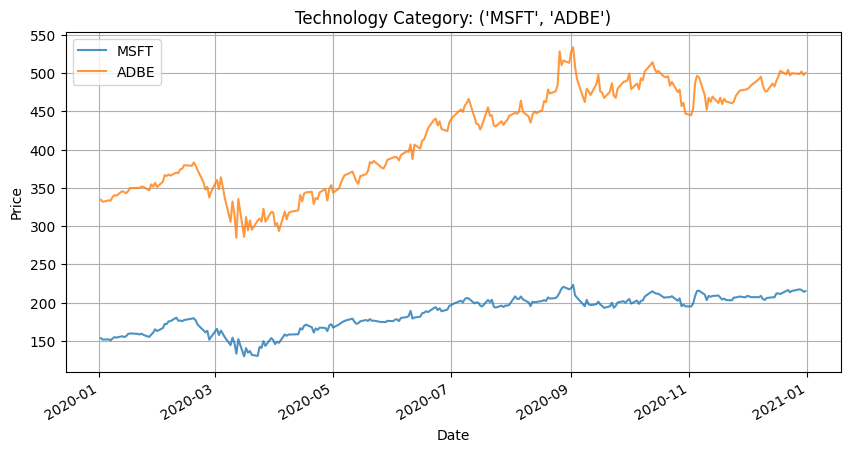

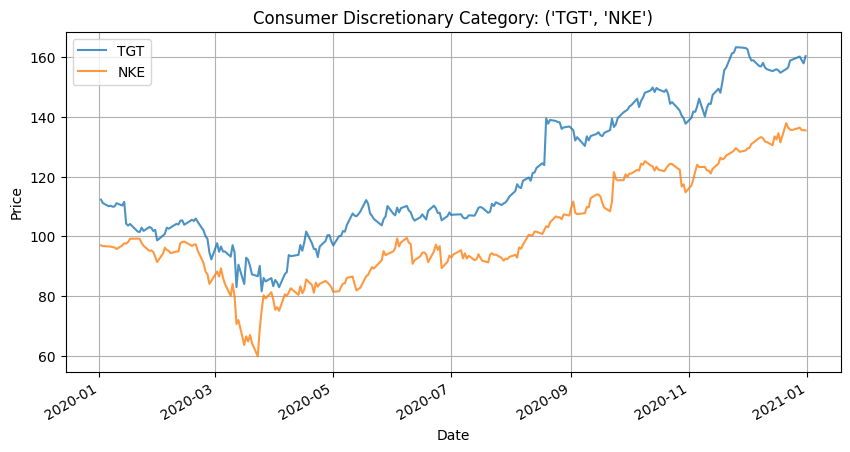

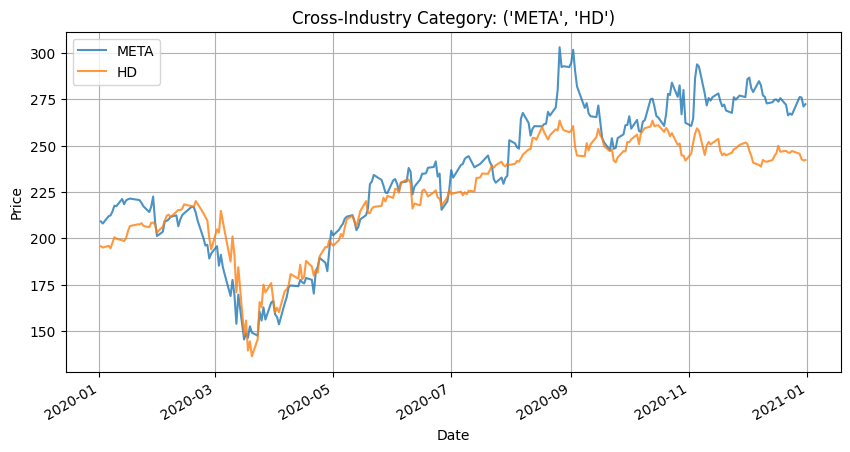

In [3]:
import matplotlib.pyplot as plt

def visualize_pair(data, pair, title):
    plt.figure(figsize=(10, 5))
    data[pair[0]].plot(label=pair[0], alpha=0.8)
    data[pair[1]].plot(label=pair[1], alpha=0.8)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

for category, best_pair in [
    ('Technology', best_tech_pair),
    ('Consumer Discretionary',best_consumer_pair),
    ('Cross-Industry', best_cross_pair)
]:
    visualize_pair(formation_data, best_pair, f"{category} Category: {best_pair}")

## 5. Trading Strategy Implementation
### Overview
Once the best pairs are identified during the formation period, we simulate the trading strategy over the 6-month trading period. The trading strategy seeks to exploit deviations in the price spread between the two stocks in each pair, assuming the spread will revert to its historical mean.

---

### Strategy Rules
- Entry Condition:
    - A position is opened when the price spread between the two stocks in a pair deviates by more than two standard deviations from its historical mean (calculated during the formation period).
    - The strategy involves:
        - Going long on the underperforming stock (the stock with the lower price relative to the mean spread).
        - Going short on the outperforming stock (the stock with the higher price relative to the mean spread).
- Exit Condition:

    - Positions are closed when the price spread returns to the historical mean or within one standard deviation of it.
    - This ensures that profits are realized when the price relationship normalizes.


In [7]:
def calculate_spread(data, stock1, stock2):
    return data[stock1] - data[stock2]

def simulate_trading(trading_data, pair, mean_spread, std_spread):
    stock1, stock2 = pair
    spread = calculate_spread(trading_data, stock1, stock2)
    
    trades = []
    current_position = None
    entry_threshold = 2 * std_spread
    exit_threshold = mean_spread 
    
    for date, current_spread in spread.items():
        if current_position is None:
            # Entry condition
            if abs(current_spread - mean_spread) > entry_threshold:
                long_stock = stock1 if current_spread < mean_spread else stock2
                short_stock = stock2 if current_spread < mean_spread else stock1
                entry = {
                    "entry_date": date,
                    "long": long_stock,
                    "short": short_stock,
                    "long_price": round(trading_data.loc[date, long_stock], 2),
                    "short_price": round(trading_data.loc[date, short_stock], 2),
                    "entry_spread": round(current_spread, 2),
                }
                current_position = entry
        else:
            # Exit condition
            if abs(current_spread - mean_spread) <= std_spread:
                exit = {
                    "exit_date": date,
                    "exit_spread": round(current_spread, 2),
                    "long_exit_price": round(trading_data.loc[date, current_position["long"]], 2),
                    "short_exit_price": round(trading_data.loc[date, current_position["short"]], 2),
                }
                
                profit = (
                    (exit["long_exit_price"] - current_position["long_price"]) +
                    (current_position["short_price"] - exit["short_exit_price"])
                )
                
                trade = {**current_position, **exit, "profit": round(profit, 2)}
                trades.append(trade)  # Add trade to the list
                current_position = None  # Reset current position
    
    return pd.DataFrame(trades)

## 6. Performance Evaluation

In this section, we analyze the performance of the pairs trading strategy across various metrics to evaluate its profitability and risk-adjusted returns. The following performance measures will be calculated:

1. Annualized Return: Measures the strategy's average annual return over the trading periods.
2. Sharpe Ratio: Evaluates risk-adjusted performance by comparing the strategy's returns to its volatility.
3. Maximum Drawdown: Quantifies the largest peak-to-trough decline in the portfolio's value.
4. Win Rate: Determines the percentage of profitable trades out of the total trades executed.

In [8]:
def calculate_performance_metrics(trades):
    if trades.empty:
        return {"Annualized Return": 0, "Sharpe Ratio": 0, "Win Rate": 0}
    
    trades["daily_return"] = trades["profit"] / (trades["long_price"] + trades["short_price"])
    cumulative_return = (trades["daily_return"] + 1).prod() - 1
    annualized_return = ((1 + cumulative_return) ** (1 / 0.5)) - 1
    sharpe_ratio = trades["daily_return"].mean() / trades["daily_return"].std()
    win_rate = (trades["profit"] > 0).mean()
    
    return {
        "Annualized Return": round(annualized_return, 3),
        "Sharpe Ratio": round(sharpe_ratio, 3),
        "Win Rate": round(win_rate, 3)
    }

Running the strategy for multiple periods

In [27]:
results_over_periods = []

for i, (start_date, end_date) in enumerate(periods):
    data = pd.read_csv(f"stock_prices_period_{i+1}.csv", index_col=0, parse_dates=True)
    
    formation_data = data.loc[start_date:(pd.to_datetime(start_date) + pd.DateOffset(months=12) - pd.Timedelta(days=1))]
    trading_data = data.loc[(pd.to_datetime(start_date) + pd.DateOffset(months=12)):end_date]
    
    # Find best pairs for the current formation period
    tech_pairs_sorted = find_pairs_ssd(formation_data, tech_tickers)
    consumer_pairs_sorted = find_pairs_ssd(formation_data, consumer_tickers)
    cross_pairs_sorted = find_pairs_ssd(formation_data, tech_tickers, consumer_tickers)
    
    best_tech_pair = tech_pairs_sorted[0][0]
    best_consumer_pair = consumer_pairs_sorted[0][0]
    best_cross_pair = cross_pairs_sorted[0][0]
    
    # Simulate trading for the best pairs
    trading_results = []
    for category, best_pair in [
        ("Technology", best_tech_pair),
        ("Consumer Discretionary", best_consumer_pair),
        ("Cross-Industry", best_cross_pair),
    ]:
        spread = calculate_spread(formation_data, *best_pair)
        mean_spread = spread.mean()
        std_spread = spread.std()
        trades = simulate_trading(trading_data, best_pair, mean_spread, std_spread)
        
        trading_results.append({
            "Category": category,
            "Pair": best_pair,
            "Mean Spread": round(mean_spread, 2),
            "Std Spread": round(std_spread, 2),
            "Trades": trades,
        })
    
    # Evaluate performance for the current period
    performance_results = []
    for result in trading_results:
        category = result["Category"]
        trades = result["Trades"]
        metrics = calculate_performance_metrics(trades)
        metrics["Category"] = category
        performance_results.append(metrics)
    
    # Save results for this period
    results_over_periods.append({
        "Period": f"Period {i+1} ({start_date} to {end_date})",
        "Trading Results": trading_results,
        "Performance Metrics": performance_results,
    })


for period_results in results_over_periods:
    print(f"\n{period_results['Period']}:")
    for trading_result in period_results["Trading Results"]:
        print('-' * 40)
        print(f"Category: {trading_result['Category']}")
        print(f"Pair: {trading_result['Pair']}")
        number_of_trades = len(trading_result['Trades'])
        print(f"Number of Trades: {number_of_trades}")
        if number_of_trades != 0:
            display(trading_result["Trades"])
    print('-' * 40)
    print("\nPerformance Metrics:")
    performance_df = pd.DataFrame(period_results["Performance Metrics"])
    performance_df.set_index("Category", inplace=True)
    display(performance_df)
    print('-' * 80)


Period 1 (2020-01-01 to 2021-06-30):
----------------------------------------
Category: Technology
Pair: ('MSFT', 'ADBE')
Number of Trades: 0
----------------------------------------
Category: Consumer Discretionary
Pair: ('TGT', 'NKE')
Number of Trades: 1


,entry_date,long,short,long_price,short_price,entry_spread,exit_date,exit_spread,long_exit_price,short_exit_price,profit,daily_return
0,2021-01-06,NKE,TGT,136.37,171.69,35.32,2021-03-17,23.69,139.02,162.7,11.64,0.037785


----------------------------------------
Category: Cross-Industry
Pair: ('META', 'HD')
Number of Trades: 0
----------------------------------------

Performance Metrics:


,Annualized Return,Sharpe Ratio,Win Rate
Category,,,
Technology,0.000,0.0,0.0
Consumer Discretionary,0.077,NaN,1.0
Cross-Industry,0.000,0.0,0.0


--------------------------------------------------------------------------------

Period 2 (2021-07-01 to 2022-12-31):
----------------------------------------
Category: Technology
Pair: ('MSFT', 'GOOGL')
Number of Trades: 1


,entry_date,long,short,long_price,short_price,entry_spread,exit_date,exit_spread,long_exit_price,short_exit_price,profit,daily_return
0,2022-10-10,MSFT,GOOGL,224.91,97.62,127.3,2022-11-10,144.68,238.38,93.71,17.38,0.053886


----------------------------------------
Category: Consumer Discretionary
Pair: ('NKE', 'SBUX')
Number of Trades: 0
----------------------------------------
Category: Cross-Industry
Pair: ('MSFT', 'LOW')
Number of Trades: 0
----------------------------------------

Performance Metrics:


,Annualized Return,Sharpe Ratio,Win Rate
Category,,,
Technology,0.111,NaN,1.0
Consumer Discretionary,0.000,0.0,0.0
Cross-Industry,0.000,0.0,0.0


--------------------------------------------------------------------------------

Period 3 (2023-01-01 to 2024-06-30):
----------------------------------------
Category: Technology
Pair: ('MSFT', 'GOOGL')
Number of Trades: 0
----------------------------------------
Category: Consumer Discretionary
Pair: ('LOW', 'MCD')
Number of Trades: 0
----------------------------------------
Category: Cross-Industry
Pair: ('QCOM', 'COST')
Number of Trades: 0
----------------------------------------

Performance Metrics:


,Annualized Return,Sharpe Ratio,Win Rate
Category,,,
Technology,0,0,0
Consumer Discretionary,0,0,0
Cross-Industry,0,0,0


--------------------------------------------------------------------------------


## 7. Discussion and Conclusion

### Discussion on Low Trade Frequency
The strategy’s low trade frequency highlights key challenges:
1. Pair Stability: Highly stable pairs led to fewer deviations triggering trades.
2. Threshold Sensitivity: A conservative 2-standard-deviation threshold limited opportunities.
3. Market Conditions: Low-volatility periods reduced arbitrage potential.
4. Pair Selection: SSD-based selection may not have captured the most dynamic pairs.
5. Timeline Impact: Results may vary across different periods, warranting further testing.

### Conclusion
While pairs trading showed potential, its effectiveness was limited by low trade frequency, data constraints, and the exclusion of real-world factors like transaction costs. Future improvements could include dynamic models, larger datasets, and advanced metrics to enhance performance and scalability.


## **References**
1. Gatev, Evan and Goetzmann, William N. and Rouwenhorst, K. Geert, *Pairs Trading: Performance of a Relative Value Arbitrage Rule* (February 2006). Yale ICF Working Paper No. 08-03, Available at SSRN: [https://ssrn.com/abstract=141615](https://ssrn.com/abstract=141615) or [http://dx.doi.org/10.2139/ssrn.141615](http://dx.doi.org/10.2139/ssrn.141615)